<a href="https://colab.research.google.com/github/pmantramurti/CMPE257-Fall23-Pranay-Mantramurti/blob/homework/Homework_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task 1

##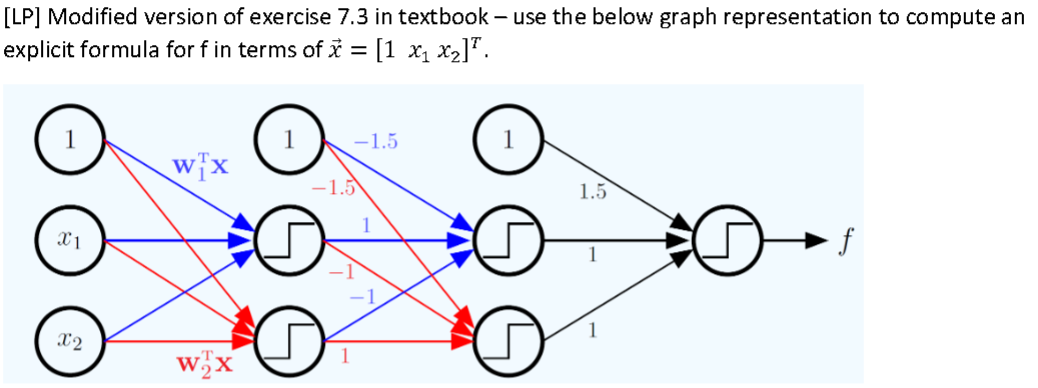

f(x) =
($\begin{pmatrix}
  1 & x_{1} & x_{2}
\end{pmatrix}$
$\begin{pmatrix}
  w_{1,0} & w_{2,0}\\
  w_{1,1} & w_{2,1}\\
  w_{1,2} & w_{2,2}
\end{pmatrix}$
$\begin{pmatrix}
  1 & -1\\
  -1 & 1
\end{pmatrix}$
+
$\begin{pmatrix}
  -1.5 & -1.5
\end{pmatrix}$)
$\begin{pmatrix}
  1\\
  1
\end{pmatrix}$
+
1.5

#Task 2

##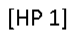

In [193]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

In [194]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [195]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/ZipDigits/ZipDigits.train', header=None, delimiter=' ')
df_test = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/ZipDigits/ZipDigits.test', header=None, delimiter=' ')
include = [1, 5]
df_train = df_train.loc[df_train[0].isin(include)]
df_test = df_test.loc[df_test[0].isin(include)]

In [196]:
df_train[0] = df_train[0].replace(5, -1)
df_test[0] = df_test[0].replace(5, -1)
df_train = df_train.drop(257, axis=1)
df_test = df_test.drop(257, axis=1)

<ipython-input-196-3ef13f2b046e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[0] = df_train[0].replace(5, -1)


In [197]:
def symmCalc(row):
  image = np.array(row[1:257]).reshape(16,16)
  left = image[:,:8]
  right = np.fliplr(image[:,8:16])
  symmDiff = np.abs(left-right)
  return (np.sum(symmDiff)/(16*8))

In [198]:
df_train_alt = pd.DataFrame()
df_test_alt = pd.DataFrame()
df_train_alt['intensity'] = df_train.mean(axis=1)
df_test_alt['intensity'] = df_test.mean(axis=1)

df_train_alt['symmetry'] = df_train.apply(symmCalc, axis=1)
df_test_alt['symmetry'] = df_test.apply(symmCalc, axis=1)
df_train_alt['bias'] = 1

df_train_alt['y'] = df_train[0]
df_test_alt['y'] = df_test[0]
df_train_alt.head(1)

,intensity,symmetry,bias,y
1,-0.115195,0.533727,1,-1.0


###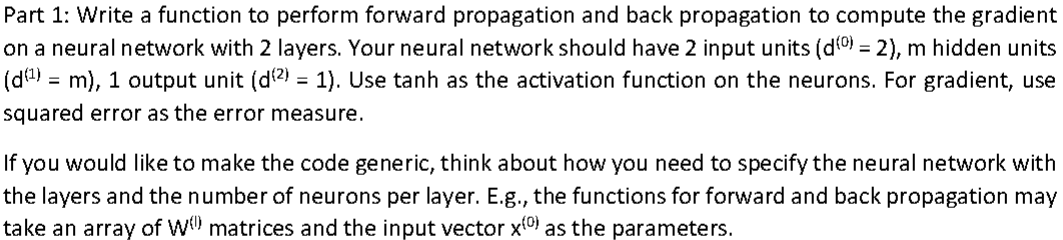

In [224]:
def init_Network(d, hidden_layers):#d = [Input units, hidden units, output units], ex : [2, m, 1]
  network_w = []
  network_v = []

  hidden_layer = [[random.random() for i in range(d[0] + 1)] for i in range(d[1])]
  hidden_input = [0 for i in range(d[1])]
  network_w.append(np.array(hidden_layer))
  network_v.append(np.array(hidden_input))

  for i in range(hidden_layers - 1):
    hidden_layer = [[random.random() for i in range(d[1] + 1)] for i in range(d[1])]
    network_w.append(np.array(hidden_layer))
    hidden_input = [0 for i in range(d[1])]
    network_v.append(np.array(hidden_input))

  out_layer = [[random.random() for i in range(d[1] + 1)] for i in range(d[2])]
  network_w.append(np.array(out_layer))
  out_input = [0 for i in range(d[2])]
  network_v.append(np.array(out_input))

  return network_w, network_v

def neuron_activation(input, weight, sample_size):
  temp_w = np.delete(weight.copy(), -1, axis=1)
  bias = np.tile([np.array(weight[:, -1])], (sample_size, 1))
  out = np.dot(temp_w, input)
  out += np.transpose(bias)
  out = np.tanh(out)
  return out

def forward_propagation(network_w, network_v, input, expected_output, sample_size):
  result = np.array([network_v.copy() for i in range(sample_size)])
  result[:, 0] = np.array(neuron_activation(np.array(input), np.array(network_w[0]), sample_size)).tolist()
  for i in range(1, len(result[0])):
    inp = np.array([row[i-1] for row in result])
    result[:, i] = np.array(neuron_activation(inp, np.array(network_w[i]), sample_size))#.tolist()
  outp = np.array([row[-1] for row in result])
  Error = np.sum((np.array(outp) - np.array(expected_output))**2)/sample_size
  result_fin = network_v.copy()
  for i in range(sample_size):
    result_fin += np.array(result[i])
  result_fin = result_fin/np.full_like(result[0], sample_size)
  return result, Error

def back_propagation(network_w, result, Error, expected_output, sample_size, learning_rate):
  gradients = [np.zeros_like(layer) for layer in network_w]
  outp = np.array([row[-1] for row in result])
  delta = -2 * (expected_output - outp) * (1 - np.tanh(np.dot(result[-2], network_w[-1].T))**2)

  for i in range(len(gradients) - 2, -1, -1):
    delta = np.dot(delta, network_w[i + 1][:, :-1]) * (1 - np.tanh(np.dot(result[i], network_w[i].T))**2)
    gradients[i] = np.dot(delta.T, result[i])

  for i in range(len(network_w)):
    network_w[i] -= learning_rate * gradients[i]

In [223]:
m = 2
d = [2, m, 1]
netW, netV = init_Network(d, 1)
input = [[1,1],[1,2]]
exp_out = [[1],[-1]]
sample_size = 2
out, err = forward_propagation(np.array(netW), np.array(netV), input, exp_out, sample_size)
print(out)
print(err)

[array([0.97560428, 0.99236154]) array([0.96492887])]
3.8621765289322587


<ipython-input-223-a6f063bbe70c>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  out, err = forward_propagation(np.array(netW), np.array(netV), input, exp_out, sample_size)


###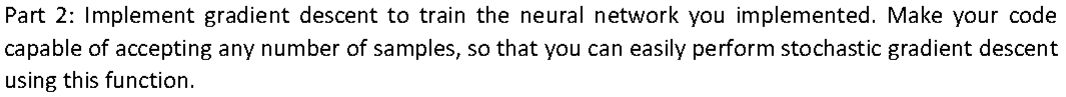

###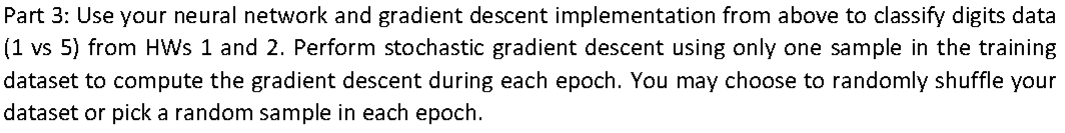

###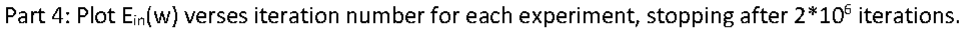

###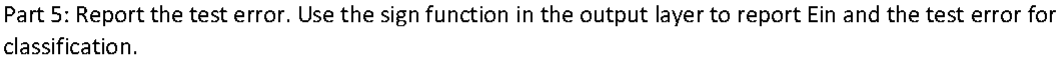

##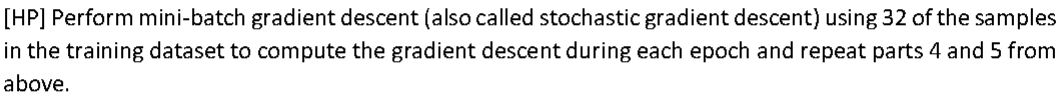